# Importing data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('app/data/laptop_price.csv', encoding='latin1')

# Data visualization

In [ ]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
df.shape

(1303, 13)

In [ ]:
df.Price_euros.describe()

count    1303.000000
mean     1123.686992
std       699.009043
min       174.000000
25%       599.000000
50%       977.000000
75%      1487.880000
max      6099.000000
Name: Price_euros, dtype: float64

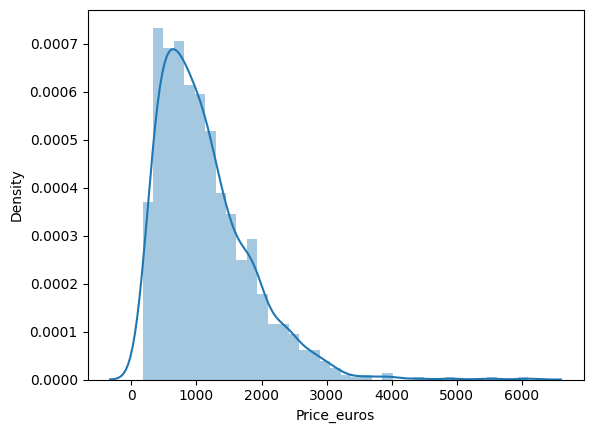

In [ ]:
sns.distplot(df.Price_euros);

In [ ]:
print(f'Skewness: {round(df.Price_euros.skew(), 2)}')
print(f'Kurtosis: {round(df.Price_euros.kurt(), 2)}')

Skewness: 1.52
Kurtosis: 4.37


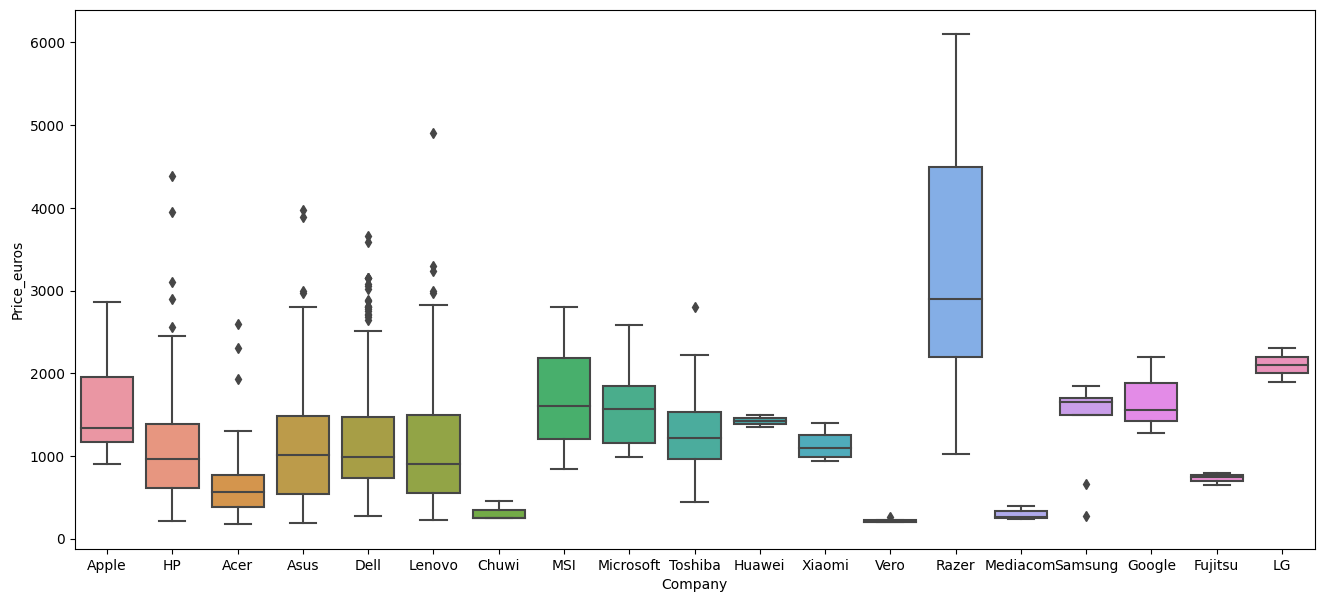

In [ ]:
data = pd.concat([df.Price_euros, df.Company], axis=1)
f, ax = plt.subplots(figsize=(16, 7))
fig = sns.boxplot(x='Company', y='Price_euros', data=data)
fig.axis();

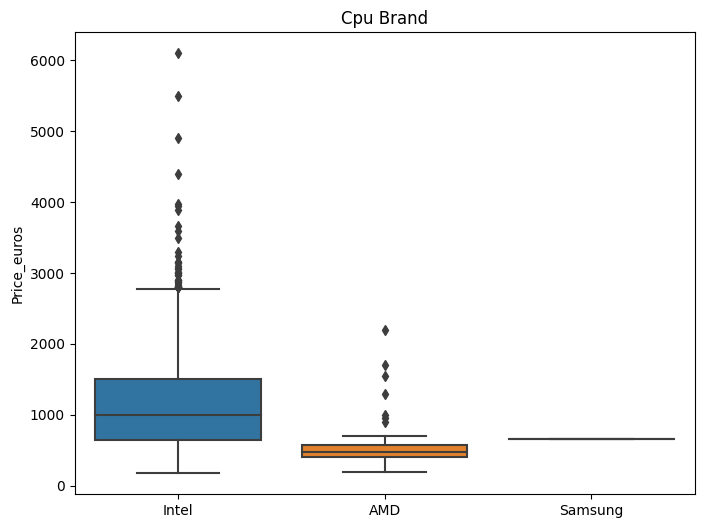

In [ ]:
var = pd.Series([x[0] for x in df.Cpu.str.split(' ')])
data = pd.concat([df.Price_euros, var], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='Price_euros', data=data)
plt.title('Cpu Brand');

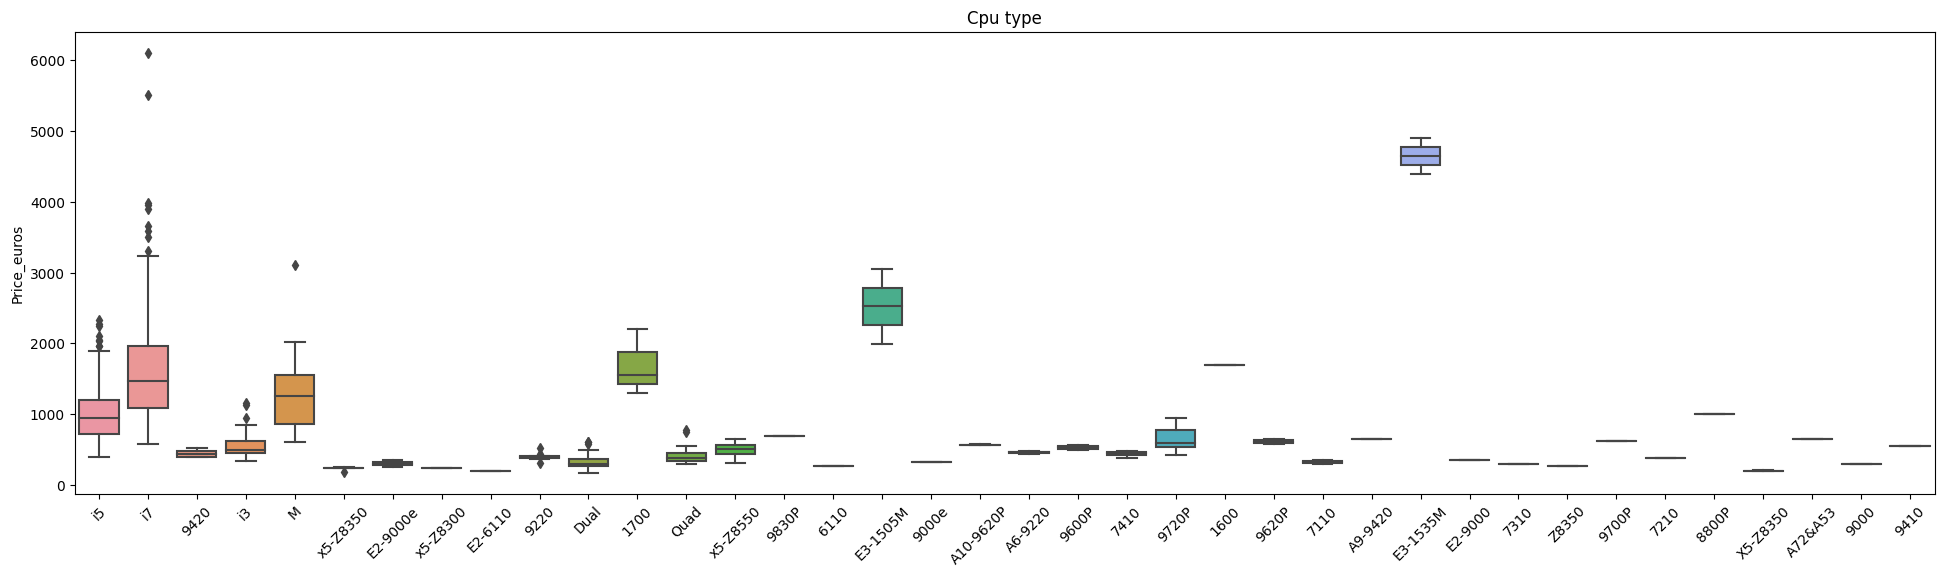

In [ ]:
var = pd.Series([x[2] for x in df.Cpu.str.split(' ')])
data = pd.concat([df.Price_euros, var], axis=1)
f, ax = plt.subplots(figsize=(24, 6))
fig = sns.boxplot(x=var, y='Price_euros', data=data)
plt.xticks(rotation=45)
plt.title('Cpu type');

**Not Working**

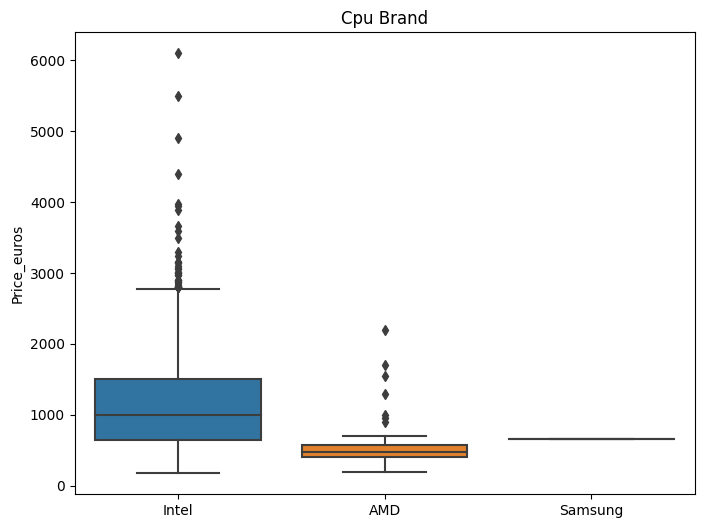

In [ ]:
var = pd.Series([x[0] for x in df.Cpu.str.split(' ')])
data = pd.concat([df.Price_euros, var], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='Price_euros', data=data)
plt.title('Cpu Brand');

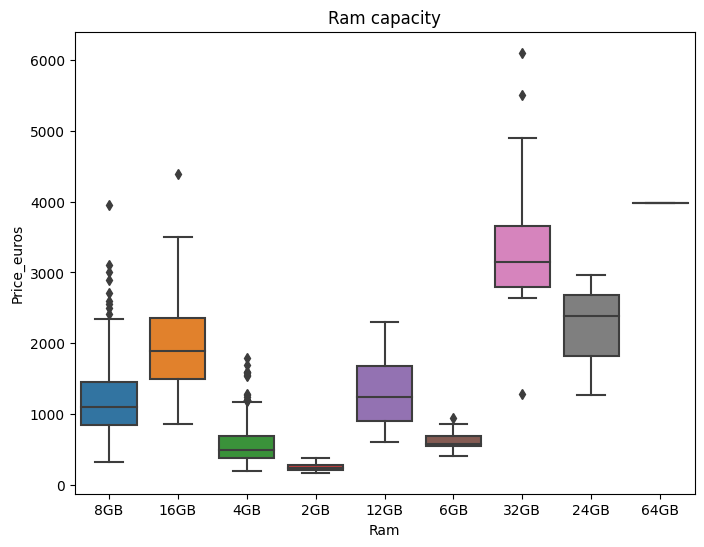

In [ ]:
data = pd.concat([df.Price_euros, df.Ram], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='Ram', y='Price_euros', data=data)
plt.title('Ram capacity');

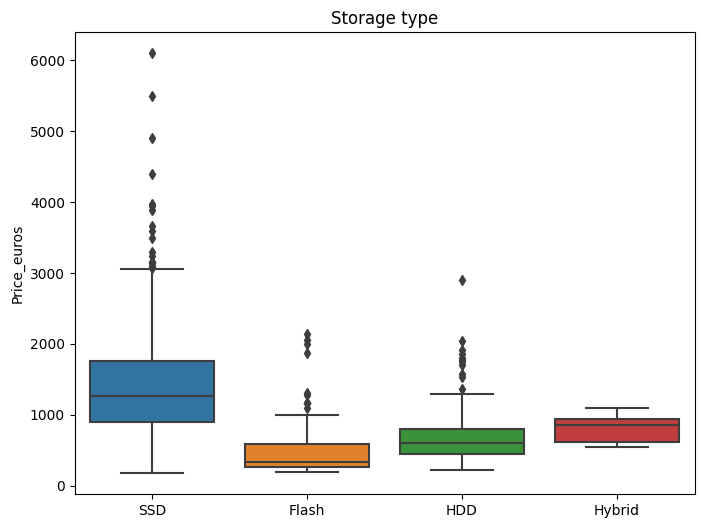

In [ ]:
var = pd.Series([x[1] for x in df.Memory.str.split(' ')])
data = pd.concat([df.Price_euros, var], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='Price_euros', data=data)
plt.title('Storage type');

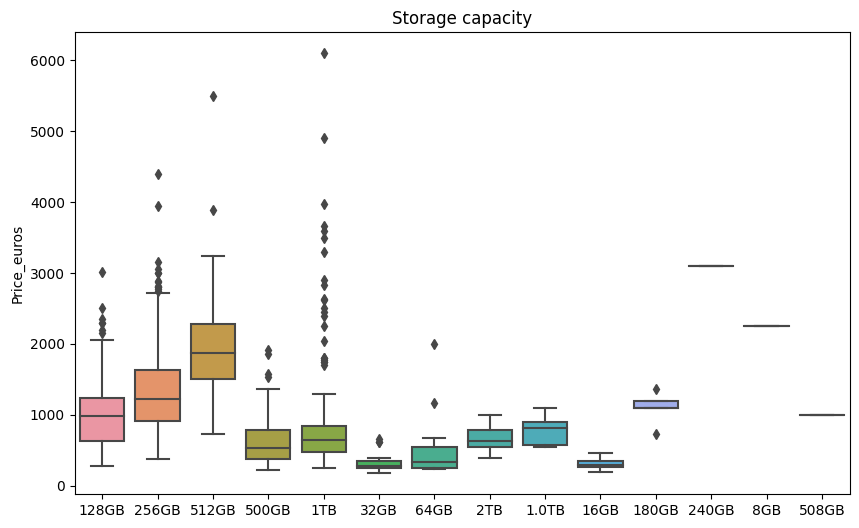

In [ ]:
var = pd.Series([x[0] for x in df.Memory.str.split(' ')])
data = pd.concat([df.Price_euros, var], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y='Price_euros', data=data)
plt.title('Storage capacity');

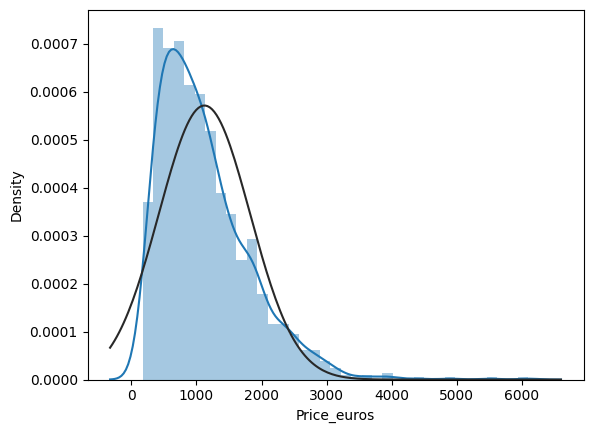

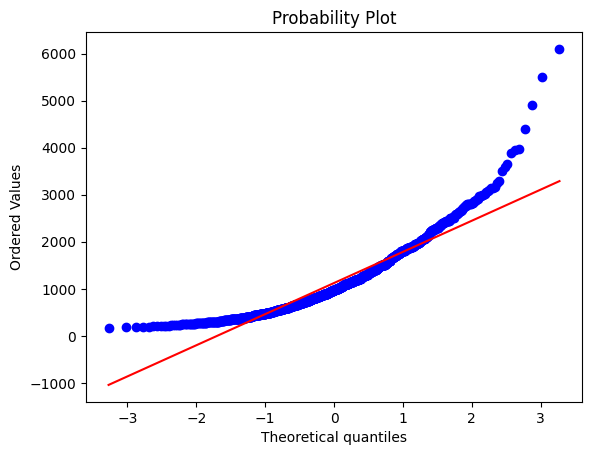

In [ ]:
sns.distplot(df['Price_euros'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Price_euros'], plot=plt)

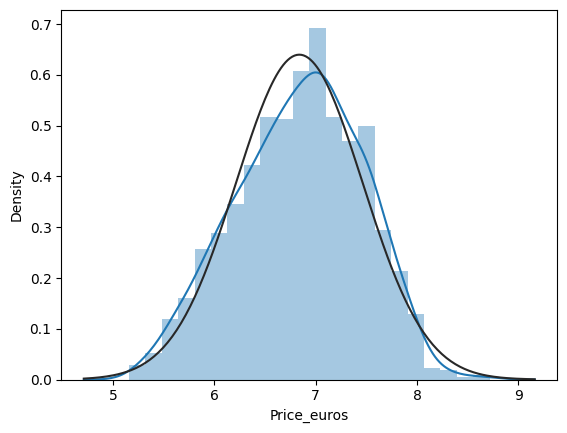

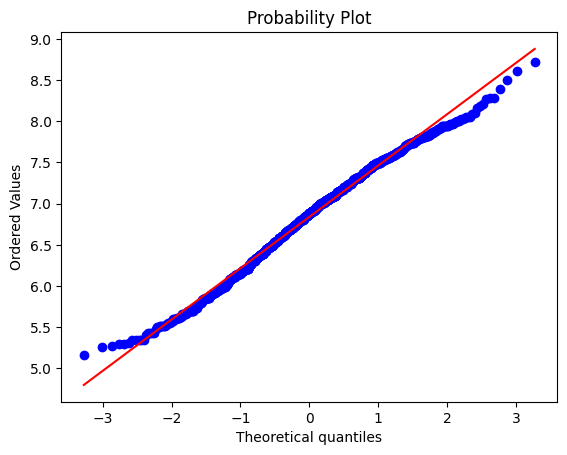

In [ ]:
sns.distplot(np.log(df['Price_euros']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df['Price_euros']), plot=plt)

# Data Processing

In [ ]:
df = pd.read_csv('laptop_price.csv', encoding='latin1')

* Delete Outliers from data visualization

In [ ]:
df = df.drop(df[df['Cpu'].str.contains('Samsung')].index, axis=0)
df = df.drop(df[df.Ram == '64GB'].index, axis=0)
df = df.drop(df[df.Memory.str.contains('240GB')].index, axis=0)
df = df.drop(df[df.Memory.str.contains('508GB')].index, axis=0)
df = df.drop(df[df.Price_euros > 4000].index, axis=0)
df = df.reset_index(drop=True)

# Product feature is similar to company featuure
df = df.drop(['laptop_ID', 'Product', 'Gpu'], axis=1) 

* Screen Resolution

In [ ]:
class ScreenExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Screen resolution:
        X['Screen'] = X.ScreenResolution.str.split().str[-1]

        # Screen touch:
        X['Screen_touch'] = X['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)

        # Screen type:
        X['Screen_type'] = X['ScreenResolution'].apply(lambda x: 'IPS Panel' if 'IPS Panel' in x
                                                      else 'Retina Display' if 'Retina Display' in x
                                                      else 'Full HD' if 'Full HD' in x
                                                      else 'Quad HD+' if 'Quad HD+' in x
                                                      else '4K Ultra HD' if '4K Ultra HD' in x
                                                      else 'NaN')
        return X.drop('ScreenResolution', axis=1)

* Cpu

In [ ]:
class CpuExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Cpu_brand'] = X['Cpu'].str.split(' ').str[0]
        X['Cpu_type'] = X['Cpu'].apply(lambda cpu: cpu.split(' ')[2] if cpu.split(' ')[0] == 'Intel' else cpu.split(' ')[1])
        X['Cpu_speed'] = X.Cpu.str.extract("(\d\.?\d*)GHz", expand=False).astype(float)
        return X.drop(['Cpu'], axis=1)

* Weight

In [ ]:
class WeightExtractor(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X['Weight'] = X['Weight'].str.replace('kg', '').astype(float)
    X.rename(columns={'Weight': 'Weight(kg)'}, inplace=True)
    return X

* Memory

In [ ]:
class MemoryTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X['Memory_capacity'] = X.Memory.str.split(' ', expand=True).iloc[:, 0]
    X['Memory_capacity'] = X['Memory_capacity'].apply(lambda x: float(x[:-2])*1000 if x.endswith('TB') else float(x[:-2]))

    X['Memory_type'] = X.Memory.str.extract("[GB|TB]\s(.*)", expand=False)
    X['Memory_type'] = X.Memory_type.str.extract(r'(\w+)')
    return X.drop(['Memory'], axis=1)

* Processing

In [ ]:
split_pipeline = Pipeline([
    ('Weight', WeightExtractor()),
    ('Cpu', CpuExtractor()),
    ('Memory', MemoryTransformer()),
    ('screen', ScreenExtractor()),
])

df = split_pipeline.fit_transform(df)

* Categories features

In [ ]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    ordinal_encoder = OrdinalEncoder()
    X[self.cols] = ordinal_encoder.fit_transform(X[self.cols])
    return X

In [ ]:
cat_cls = df.select_dtypes('object').columns.tolist()
encoder_pipeline = Pipeline([
    ('Encoder', FeatureEncoder(cols = cat_cls))
])

df = encoder_pipeline.fit_transform(df)

In [ ]:
df

,Company,TypeName,Inches,Ram,OpSys,Weight(kg),Price_euros,cpu_brand,cpu_type,cpu_capacity,Memory_capacity,Memory_type,screen_resolution,screen_type
0,Apple,Ultrabook,13.3,8GB,macOS,1.37,1339.69,Intel,i5,2.3,128.0,SSD,2560x1600,IPS
1,Apple,Ultrabook,13.3,8GB,macOS,1.34,898.94,Intel,i5,1.8,128.0,Flash Storage,1440x900,1440x900
2,HP,Notebook,15.6,8GB,No OS,1.86,575.00,Intel,i5,2.5,256.0,SSD,1920x1080,Full
3,Apple,Ultrabook,15.4,16GB,macOS,1.83,2537.45,Intel,i7,2.7,512.0,SSD,2880x1800,IPS
4,Apple,Ultrabook,13.3,8GB,macOS,1.37,1803.60,Intel,i5,3.1,256.0,SSD,2560x1600,IPS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,Lenovo,2 in 1 Convertible,14.0,4GB,Windows 10,1.80,638.00,Intel,i7,2.5,128.0,SSD,1920x1080,IPS
1291,Lenovo,2 in 1 Convertible,13.3,16GB,Windows 10,1.30,1499.00,Intel,i7,2.5,512.0,SSD,3200x1800,IPS
1292,Lenovo,Notebook,14.0,2GB,Windows 10,1.50,229.00,Intel,Dual,1.6,64.0,Flash Storage,1366x768,1366x768
1293,HP,Notebook,15.6,6GB,Windows 10,2.19,764.00,Intel,i7,2.5,1000.0,HDD,1366x768,1366x768


# Exploratory Data Analysis EDA


In [ ]:
df1 = pd.read_csv('laptop-clean.csv')

df1.head()

,Company,TypeName,Inches,Ram(GB),OpSys,Weight(kg),Price_euros,cpu_type,cpu_capacity,product_brand,product_type,Memory_capacity,Memory_type
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,i5,2.3,MacBook,Pro,128.0,SSD
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,i5,1.8,Macbook,Air,128.0,Flash Storage
2,HP,Notebook,15.6,8,No OS,1.86,575.00,i5,2.5,250,G6,256.0,SSD
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,i7,2.7,MacBook,Pro,512.0,SSD
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,i5,3.1,MacBook,Pro,256.0,SSD


**Which brand is the most frequent in the dataframe?**

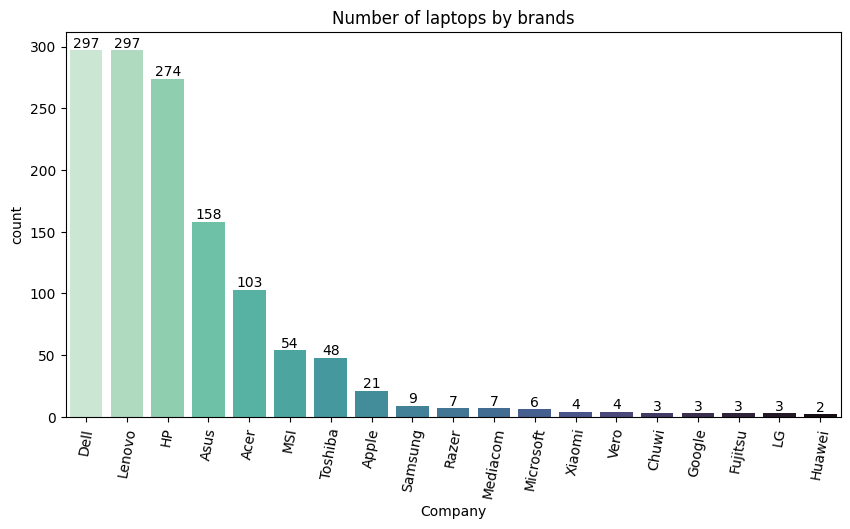

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x = 'Company', data = df1, palette = 'mako_r', order = df1['Company'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
ax.bar_label(ax.containers[0])
plt.title('Number of laptops by brands')

plt.savefig('LaptopsByBrands.png')

plt.show()

**What type of laptop is the most frequent?**

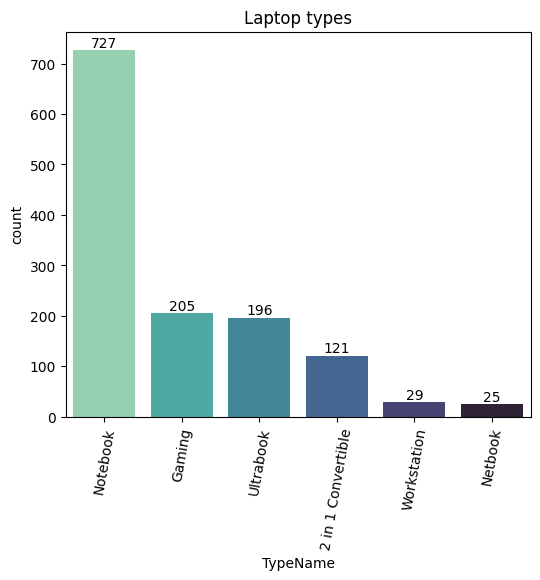

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax = sns.countplot(x='TypeName', data = df1, palette = 'mako_r', order = df1['TypeName'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
ax.bar_label(ax.containers[0])
plt.title('Laptop types')

plt.savefig('laptopTypes.png')

plt.show()

In [ ]:
print('Most laptops are notebooks, which make {:.2f}% of the total laptops'.format(len(df1[df1['TypeName']=='Notebook'])*100/len(df1)))

Most laptops are notebooks, which make 55.79% of the total laptops


**Which size is the most popular?**

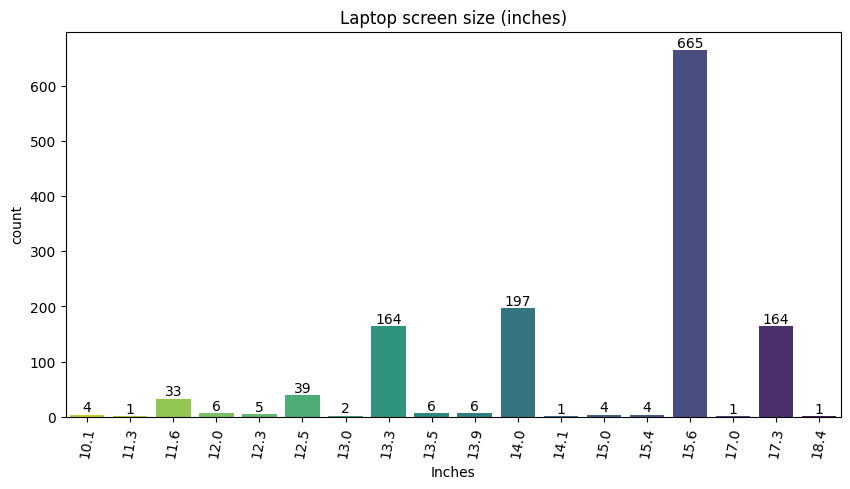

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x = 'Inches', data = df1, palette = 'viridis_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
ax.bar_label(ax.containers[0])
plt.title('Laptop screen size (inches)')

plt.savefig('screenSizeInches.png')

plt.show()

In [ ]:
print('Most laptops have 15.6 inches, which make {:.2f}% of the total laptops'.format(len(df1[df1['Inches']==15.6])*100/len(df1)))

Most laptops have 15.6 inches, which make 51.04% of the total laptops


**Distribution of Hard Drive**

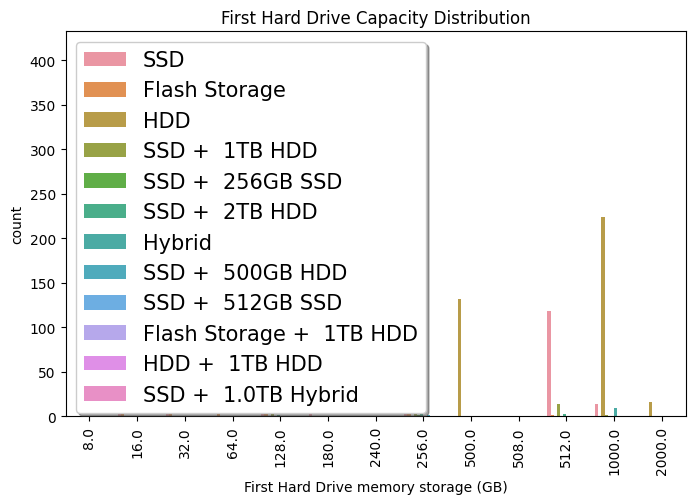

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(x = 'Memory_capacity', data = df1, hue='Memory_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('First Hard Drive memory storage (GB)')
plt.title('First Hard Drive Capacity Distribution')
plt.legend(loc='upper left', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)

plt.savefig('hardCapacity.png')

plt.show()

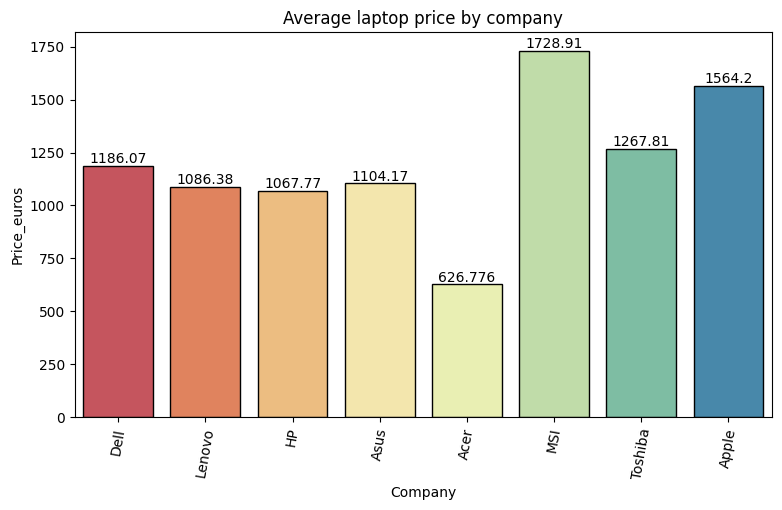

In [ ]:
company_list = df1['Company'].value_counts().index[:8].tolist()

plt.figure(figsize=(9,5))
ax = sns.barplot(x = 'Company', y='Price_euros', data = df1[df1['Company'].isin(company_list)],
                 order = company_list,
                 palette = 'Spectral',
                 ci = False,
                 edgecolor = 'black')
plt.xticks(rotation = 80)
ax.bar_label(ax.containers[0])
plt.title('Average laptop price by company')

plt.savefig('averagePrice.png')

plt.show()

-MSI laptops are on average the most expensive, with an average price of 1728.91$.

-Apple laptops are the second most expensive laptops and Toshiba's are 3rd.

-Acer are the cheapest, with an average price of 627$

-Laptops from Dell, Lenovo, HP and Asus have, on average, a price around 1000$

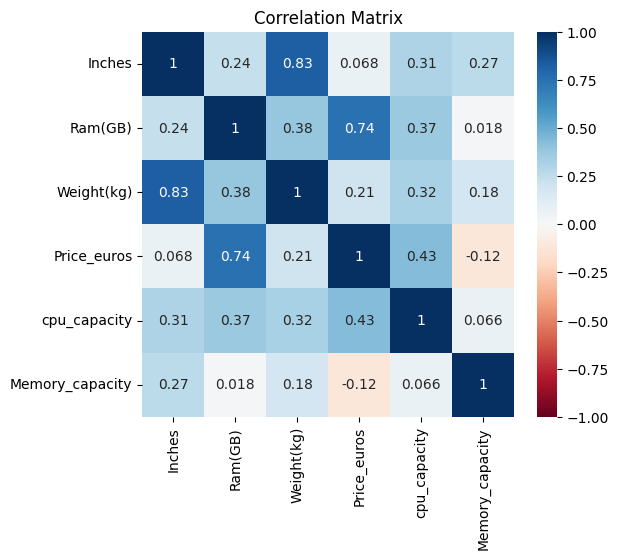

In [ ]:
plt.figure(figsize = (6,5))
sns.heatmap(df1.corr(), cmap='RdBu', annot = True, vmin = -1, vmax = 1)
plt.title('Correlation Matrix')

plt.savefig('correlation.png')

plt.show()

# Model

In [ ]:
X, y = df.drop('Price_euros', axis=1), df['Price_euros']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
print(f"Train score: {round(xgb.score(X_train, y_train), 4) * 100} % \nTest score: {round(xgb.score(X_test, y_test), 4) * 100} %")

Train score: 99.68 % 
Test score: 92.66 %


In [ ]:
y_pred_xgb = xgb.predict(X_test)

In [ ]:
print(f"Error: {round(mean_absolute_error(np.exp(y_test), np.exp(y_pred_xgb)), 2)} $")

Error: 140.97 $


In [ ]:
mse_xgb = mean_squared_error(np.exp(y_test), np.exp(y_pred_xgb))
print("RMSE with XGBoost : {:.2f} $".format(np.round(np.sqrt(mse_xgb),2)))

RMSE with XGBoost : 219.62 $


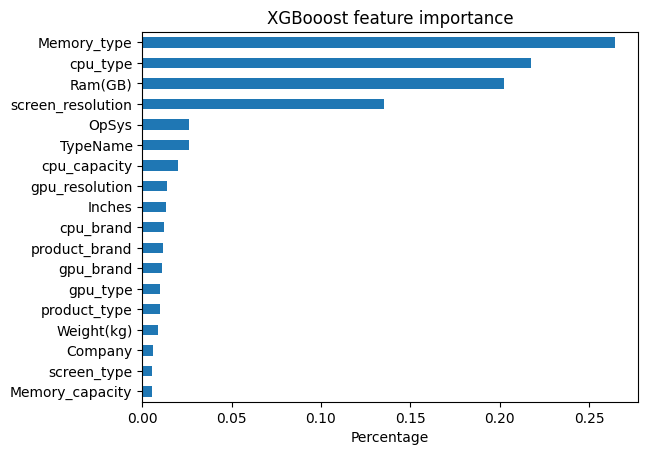

In [ ]:
pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh');
plt.xlabel('Percentage')
plt.title('XGBooost feature importance')
plt.savefig('XGBfeatureimportance.png')
plt.show();

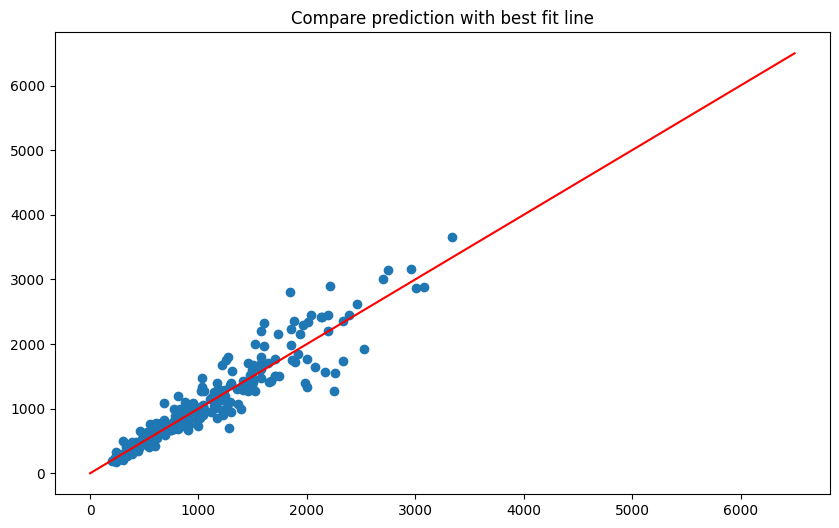

In [ ]:
plt.figure(figsize = (10,6))
plt.scatter(np.exp(y_pred_xgb), np.exp(y_test))
plt.plot(range(0, 6500), range(0, 6500), c='r')
plt.title('Compare prediction with best fit line');

**Optimization**

In [ ]:
xgb_params = {'eta': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6, 'seed': 2018, 'objective': 'reg:squarederror'}

max_depths = [4, 5, 6, 7, 8, 10]

for depth in max_depths:
    xgb_opt = XGBRegressor(max_depth=depth, **xgb_params)
    xgb_opt.fit(X_train, y_train)

    y_pred_opt = xgb_opt.predict(X_test)

    print(f"depth = {depth}")

    print(f"Train score: {round(xgb_opt.score(X_train, y_train), 4) * 100}% \nTest score: {round(xgb_opt.score(X_test, y_test), 4) * 100}%")

    print(f"Error: {round(mean_absolute_error(np.exp(y_test), np.exp(y_pred_opt)), 2)} $")

    print()


depth = 4
Train score: 95.98% 
Test score: 93.28%
Error: 140.57 $

depth = 5
Train score: 97.14% 
Test score: 93.49%
Error: 133.74 $

depth = 6
Train score: 97.91% 
Test score: 93.7%
Error: 135.9 $

depth = 7
Train score: 98.61% 
Test score: 93.87%
Error: 132.28 $

depth = 8
Train score: 99.06% 
Test score: 94.11%
Error: 127.19 $

depth = 10
Train score: 99.55000000000001% 
Test score: 94.08999999999999%
Error: 131.16 $



In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb_params = {'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.6, 'seed': 2018, 'objective': 'reg:squarederror'}

# Different values of eta to try
etas = [0.05, 0.1, 0.3]

for eta in etas:
    xgb_opt = XGBRegressor(eta=eta, **xgb_params)
    xgb_opt.fit(X_train, y_train)

    y_pred_opt = xgb_opt.predict(X_test)

    print(f"eta = {eta}")
    print(f"Train score: {round(xgb_opt.score(X_train, y_train), 4) * 100}% \nTest score: {round(xgb_opt.score(X_test, y_test), 4) * 100}%")

    print(f"Error: {round(mean_absolute_error(np.exp(y_test), np.exp(y_pred_opt)), 2)} $")

    print()


eta = 0.05
Train score: 95.96000000000001% 
Test score: 92.91%
Error: 148.8 $

eta = 0.1
Train score: 99.06% 
Test score: 94.11%
Error: 127.19 $

eta = 0.3
Train score: 99.83999999999999% 
Test score: 91.72%
Error: 149.76 $

